# Rain Prediction

**AIM-** Predicting next day rain in Australia

**Dataset Information**

- This dataset contains about 10 years of daily weather observations from many locations across Australia.
- Observations were drawn from numerous weather stations
- There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not.

- Dataset [Source](http://www.bom.gov.au/climate/data)

**Attribute Information**
Following weather attributes at various times were measuered:
- Temperature
- Wind Gust Direction
- Wind Speed
- Humidity
- Pressure
- Rainfall amount

# 0. Required Imports 

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import Sequential
from keras import regularizers
from keras import callbacks

from imblearn.combine import SMOTETomek

In [5]:
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use("dark_background")
np.random.seed(1)

# 1. Data Collection 

In [ ]:
df = pd.read_csv("'../../Dataset\weatherAUS.csv'")

In [7]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**Checking datatype of features**

In [8]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

# 2. Exploratory Data Analysis

## 2.1. Checking for the null values

In [9]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

<Axes: >

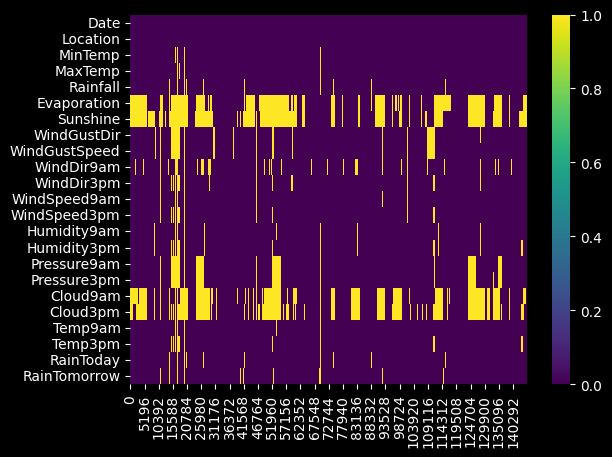

In [10]:
sns.heatmap(df.isna().T, cmap='viridis', cbar=True)

**Observations:** Their are missing values in all the features and need to be handled.

## 2.2. Dataset Description

In [11]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


## 2.3. Detecting Outliers

In [12]:
num_features = [feature for feature in df.columns if df[feature].dtype !="O"]

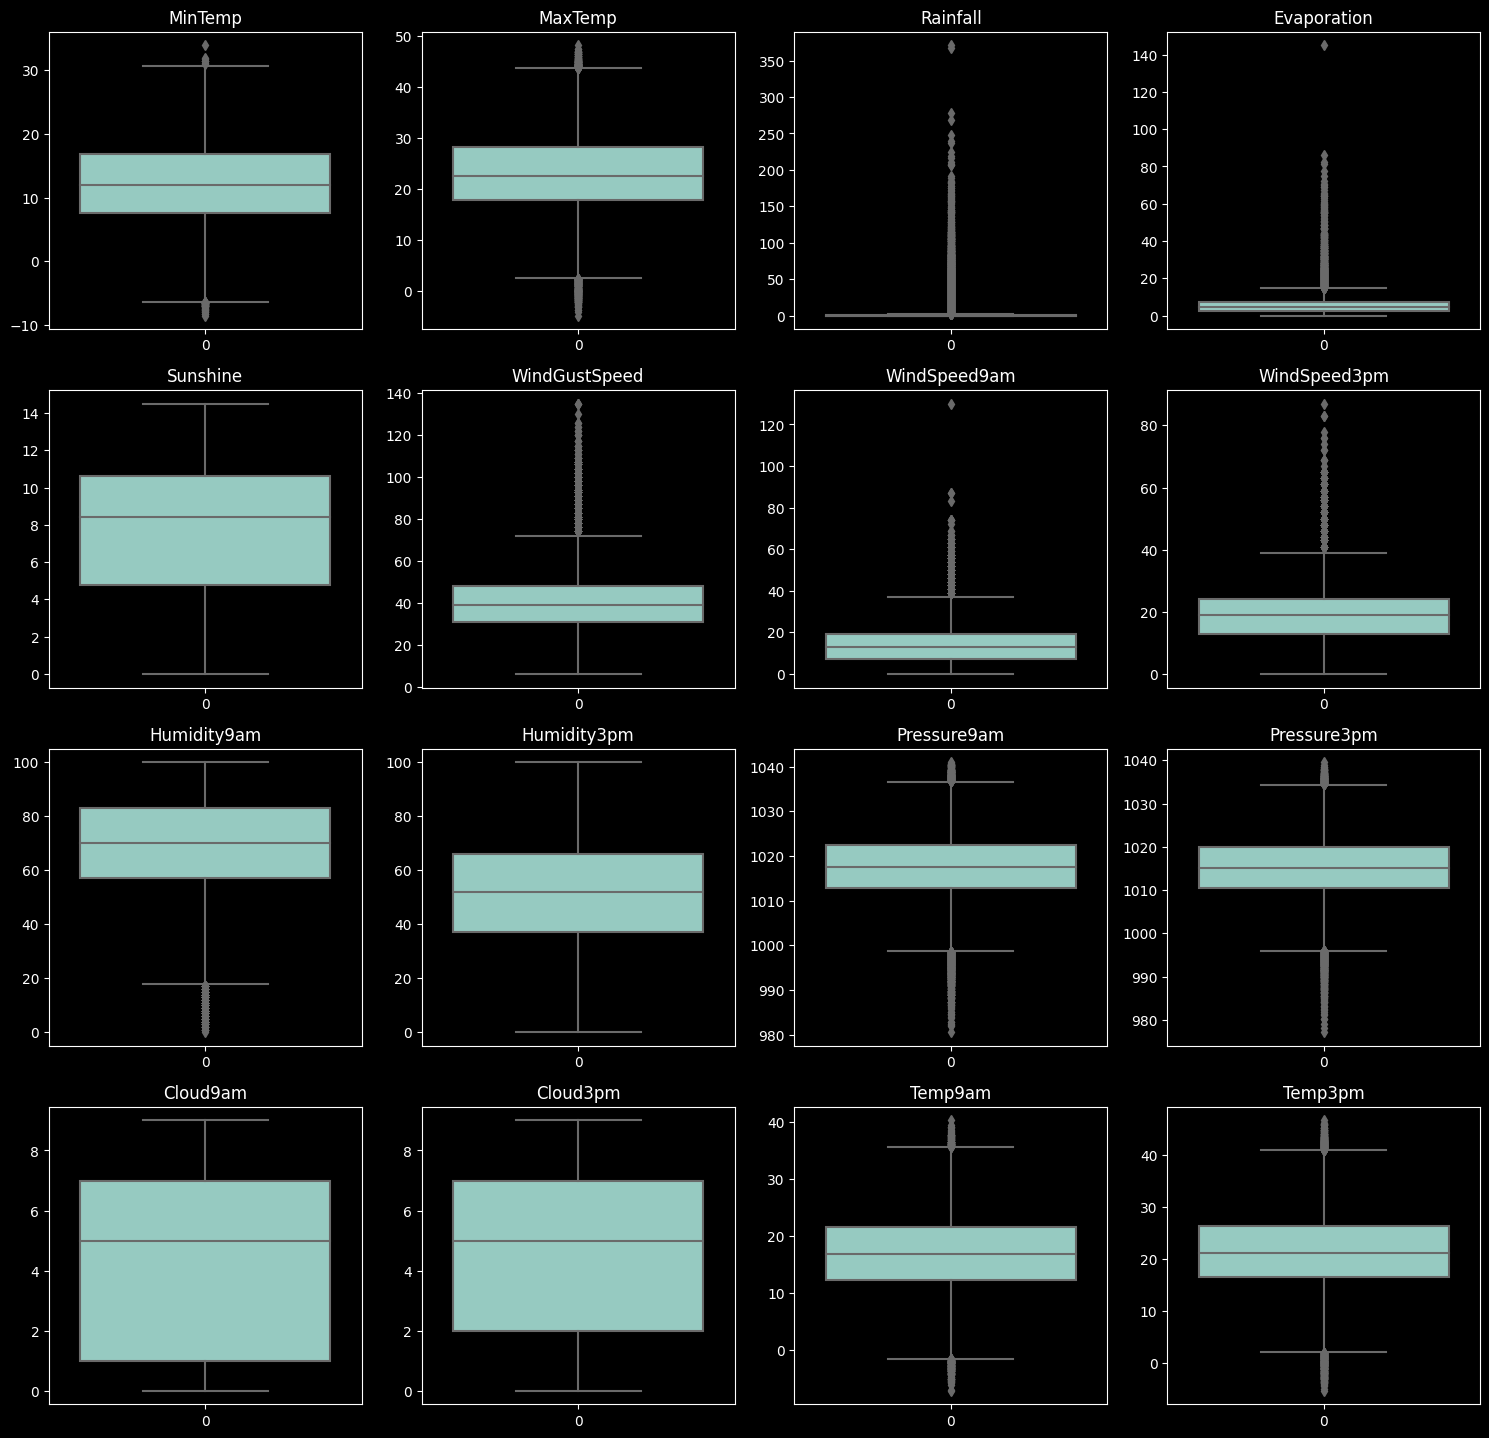

In [13]:
n = 1
plt.figure(figsize=(15, 25))
for feature in num_features:
  plt.subplot(7, 4, n, title=feature)
  n += 1
  sns.boxplot(df[feature])
  plt.tight_layout()

**Observations:** Outliers are present in several features. 

## 2.4. Checking data is balanced or not

<Axes: xlabel='RainTomorrow', ylabel='count'>

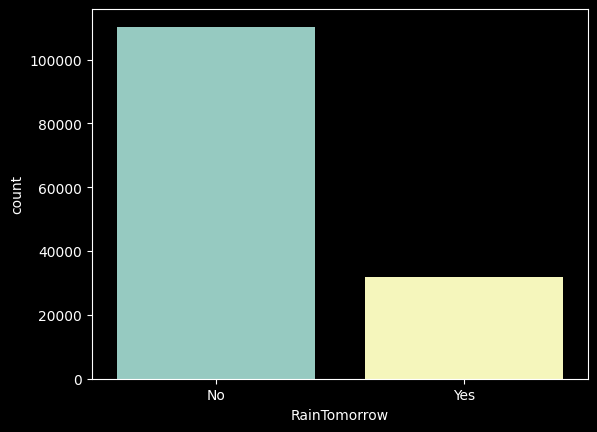

In [14]:
sns.countplot(x=df["RainTomorrow"])

**Observation:** Data is highly imbalanced and need to be balanced.

## 2.5. Checking Correlation of numeric features

<Axes: >

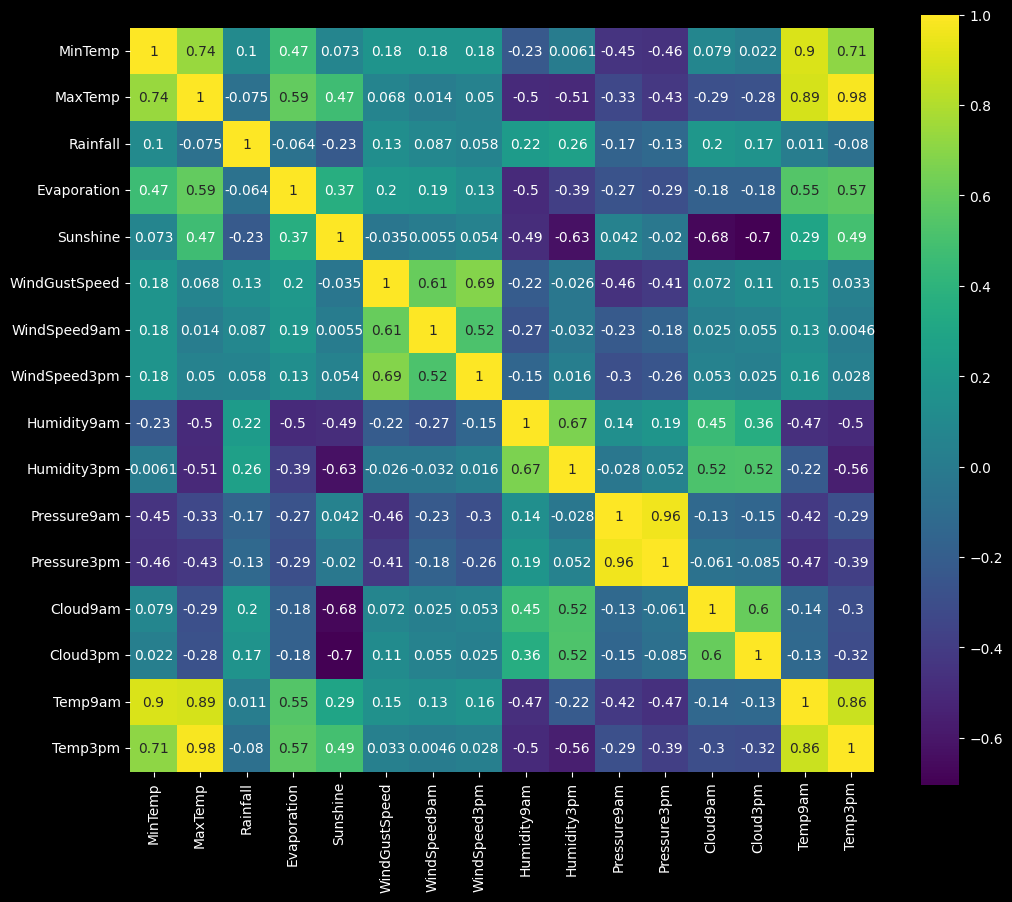

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="viridis", annot=True, square=True, cbar=True)

**Observations:**
- `MinTemp` highly correlated with `Temp9am`
- `MaxTemp` highly correalted with `Temp9am` and `Temp3pm`
- `Pressure` highly correalted with `Pressure3pm`
- `Temp9am` hihgly correalted with `Temp3pm`

## 2.6. Checking Count of Target feature

<Axes: xlabel='RainTomorrow', ylabel='count'>

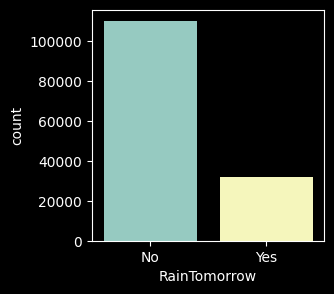

In [16]:
plt.figure(figsize=(3,3))

sns.countplot(df, x="RainTomorrow")

**Observations:** Data is higly imbalanced we need to make it balanced.

## 2.7. Parsing Dates into DateTime type

- Encode the dates in cyclic continous features consisting of days and months.
- This will let ANN know that features is cyclical.
- Split the feature in periodic subsection namely years, months & days.
- For each subsection create two new features deriving a sine transform and cosine transform of the subsection feature. 

In [17]:
lengths = df["Date"].str.len()
lengths.value_counts()

10    145460
Name: Date, dtype: int64

Their is no issue with date length so now parse the values into datetime object

In [18]:
# Parsing Date to DateTime object
df["Date"] = pd.to_datetime(df["Date"])

# Creating a column for the year subsection
df["year"] = df.Date.dt.year

# Creating a column for the month subsection
df["month"] = df.Date.dt.month

# Creating a column for the day subsection
df["day"] = df.Date.dt.day

Function to pass the DateTime object into Cyclic Parameter

In [19]:
def encode(df, col, max_val):
  df[col + "_sin"] = np.sin(2 * np.pi * df[col] /max_val)
  df[col + "_cos"] = np.cos(2 * np.pi * df[col] /max_val)

  return df

Parsing the DateTime object into cyclic parameter

In [20]:
df = encode(df, "month", 12)
df = encode(df, "day", 31)

In [21]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'year', 'month', 'day',
       'month_sin', 'month_cos', 'day_sin', 'day_cos'],
      dtype='object')

## 2.8. Distribution of Days over a year span

Text(0.5, 0, 'Days In Year')

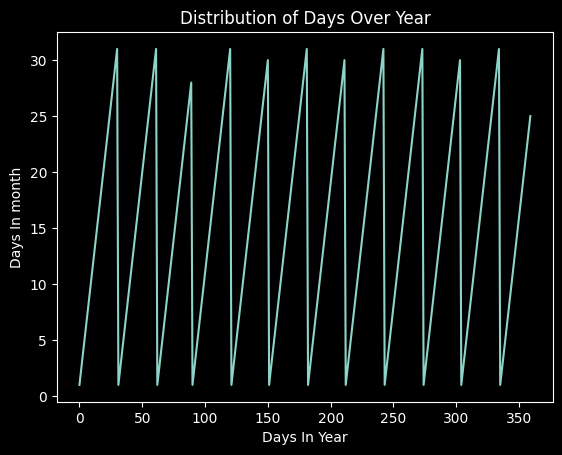

In [22]:
section = df["day"][:360] # this much rows as 360 days in a year

s = section.plot()
s.set_title("Distribution of Days Over Year")
s.set_ylabel("Days In month")
s.set_xlabel("Days In Year")


**Observations:** 
- Year attribute of the data repeats, that means it will noy represent the true continous cyclic nature of data.
- To represent the true cyclic nature of the data we would use the the sine and cosine combinations to get the results.

## 2.9. Sine and Cosine Encoded Months and Days representing cyclic nature

**Cyclic Month**

Text(0.5, 0, 'Sine Encoded Months')

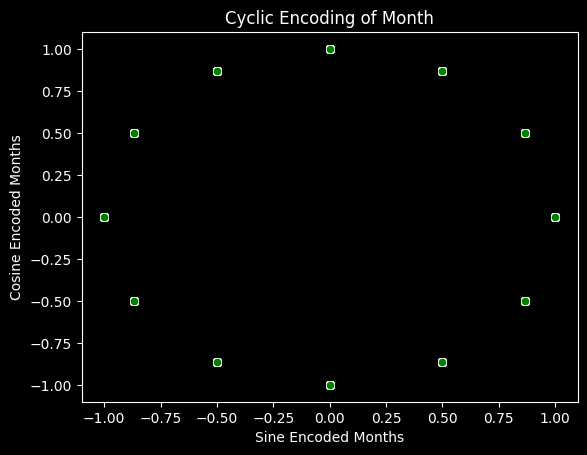

In [23]:
cyclic_month = sns.scatterplot(data=df, x="month_sin",y="month_cos", color="green")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

**Cyclic Day**

Text(0.5, 0, 'Sine Encoded Day')

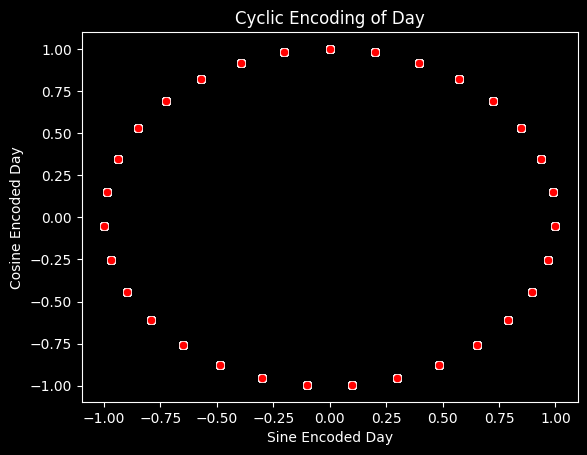

In [24]:
cyclic_day = sns.scatterplot(data=df, x='day_sin',y='day_cos', color="red")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

# 3. Data Preprocessing

## 3.1. Dropping irrelevant features for ANN

In [25]:
df.drop(['Date','day', 'month'], axis=1, inplace=True)

## 3.2. Filling Missing values

Getting list of categorical and numerical features seperately

In [26]:
cat_features, num_features = [], []

for feature in df.columns:
  if df[feature].dtype =="O":
    cat_features.append(feature)
  else:
    num_features.append(feature)

### 3.2.1. Filling Categorical Variables

Number of missing values in Categorical features

In [27]:
for cat_feature in cat_features:
  print(cat_feature, df[cat_feature].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


Filling the missing values by the mode of the feature

In [28]:
for cat_feature in cat_features:
  df[cat_feature].fillna(df[cat_feature].mode()[0], inplace=True)

### 3.2.2. Filling Numerical Variables

Number of missing values in numerical features

In [29]:
for num_feature in num_features:
  print(num_feature, df[num_feature].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
year 0
month_sin 0
month_cos 0
day_sin 0
day_cos 0


Filling the missing values with median of the feature

In [30]:
for num_feature in num_features:
  df[num_feature].fillna(df[num_feature].median(), inplace=True)

Verifying if any null values present

In [31]:
df.isna().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
month_sin        0
month_cos        0
day_sin          0
day_cos          0
dtype: int64

## 3.3. Treating Outliers

Now we will calculate the IQR for these two numerical features only which have outliers in them and then will calculate the lower and higher fence for these features respectively.

```
    IQR = Q3 - Q1    
    LF = Q1 - 1.5 * IQR 
    HF = Q3 + 1.5 * IQR
```

All numerical features except the calculated ones and date ones are to be treated for outleirs

In [32]:
features_with_outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                          'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']

In [33]:
outlier_features_IQR = {}
lower_fences = {}
higher_fences = {}

for feature in features_with_outliers:
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)

  IQR = Q3 - Q1

  LF = Q1 - 1.5 * IQR
  HF = Q3 + 1.5 * IQR

  outlier_features_IQR[feature] = IQR
  lower_fences[feature] = LF
  higher_fences[feature] = HF


In [34]:
outlier_features_IQR

{'MinTemp': 9.100000000000001,
 'MaxTemp': 10.2,
 'Rainfall': 0.6,
 'Evaporation': 1.2000000000000002,
 'WindGustSpeed': 15.0,
 'WindSpeed9am': 12.0,
 'WindSpeed3pm': 11.0,
 'Humidity9am': 26.0,
 'Pressure9am': 8.299999999999955,
 'Pressure3pm': 8.299999999999955,
 'Temp9am': 9.2,
 'Temp3pm': 9.5,
 'month_sin': 1.0000000000000004,
 'month_cos': 1.3660254037844388,
 'day_sin': 1.44958557445824,
 'day_cos': 1.4477250417684773}

In [35]:
lower_fences

{'MinTemp': -5.950000000000002,
 'MaxTemp': 2.700000000000001,
 'Rainfall': -0.8999999999999999,
 'Evaporation': 2.1999999999999997,
 'WindGustSpeed': 8.5,
 'WindSpeed9am': -11.0,
 'WindSpeed3pm': -3.5,
 'Humidity9am': 18.0,
 'Pressure9am': 1001.0500000000001,
 'Pressure3pm': 998.6500000000001,
 'Temp9am': -1.4999999999999982,
 'Temp3pm': 2.4499999999999993,
 'month_sin': -2.000000000000001,
 'month_cos': -2.915063509461097,
 'day_sin': -2.89917114891648,
 'day_cos': -2.930345685345507}

In [36]:
higher_fences

{'MinTemp': 30.450000000000003,
 'MaxTemp': 43.5,
 'Rainfall': 1.5,
 'Evaporation': 7.0,
 'WindGustSpeed': 68.5,
 'WindSpeed9am': 37.0,
 'WindSpeed3pm': 40.5,
 'Humidity9am': 122.0,
 'Pressure9am': 1034.25,
 'Pressure3pm': 1031.85,
 'Temp9am': 35.3,
 'Temp3pm': 40.45,
 'month_sin': 2.0000000000000004,
 'month_cos': 2.549038105676658,
 'day_sin': 2.89917114891648,
 'day_cos': 2.8605544817284025}

Inital shape of dataframe is:

In [37]:
df.shape

(145460, 27)

Now we will drop all the values of the features which are:
`higher_fence` < value < `lower_fence`

In [38]:
for feature in features_with_outliers:
  
  lower_fence = lower_fences[feature]
  higher_fence = higher_fences[feature]

  df = df[(df[feature] > lower_fence) & (df[feature] < higher_fence) ]

In [39]:
df.shape

(79343, 27)

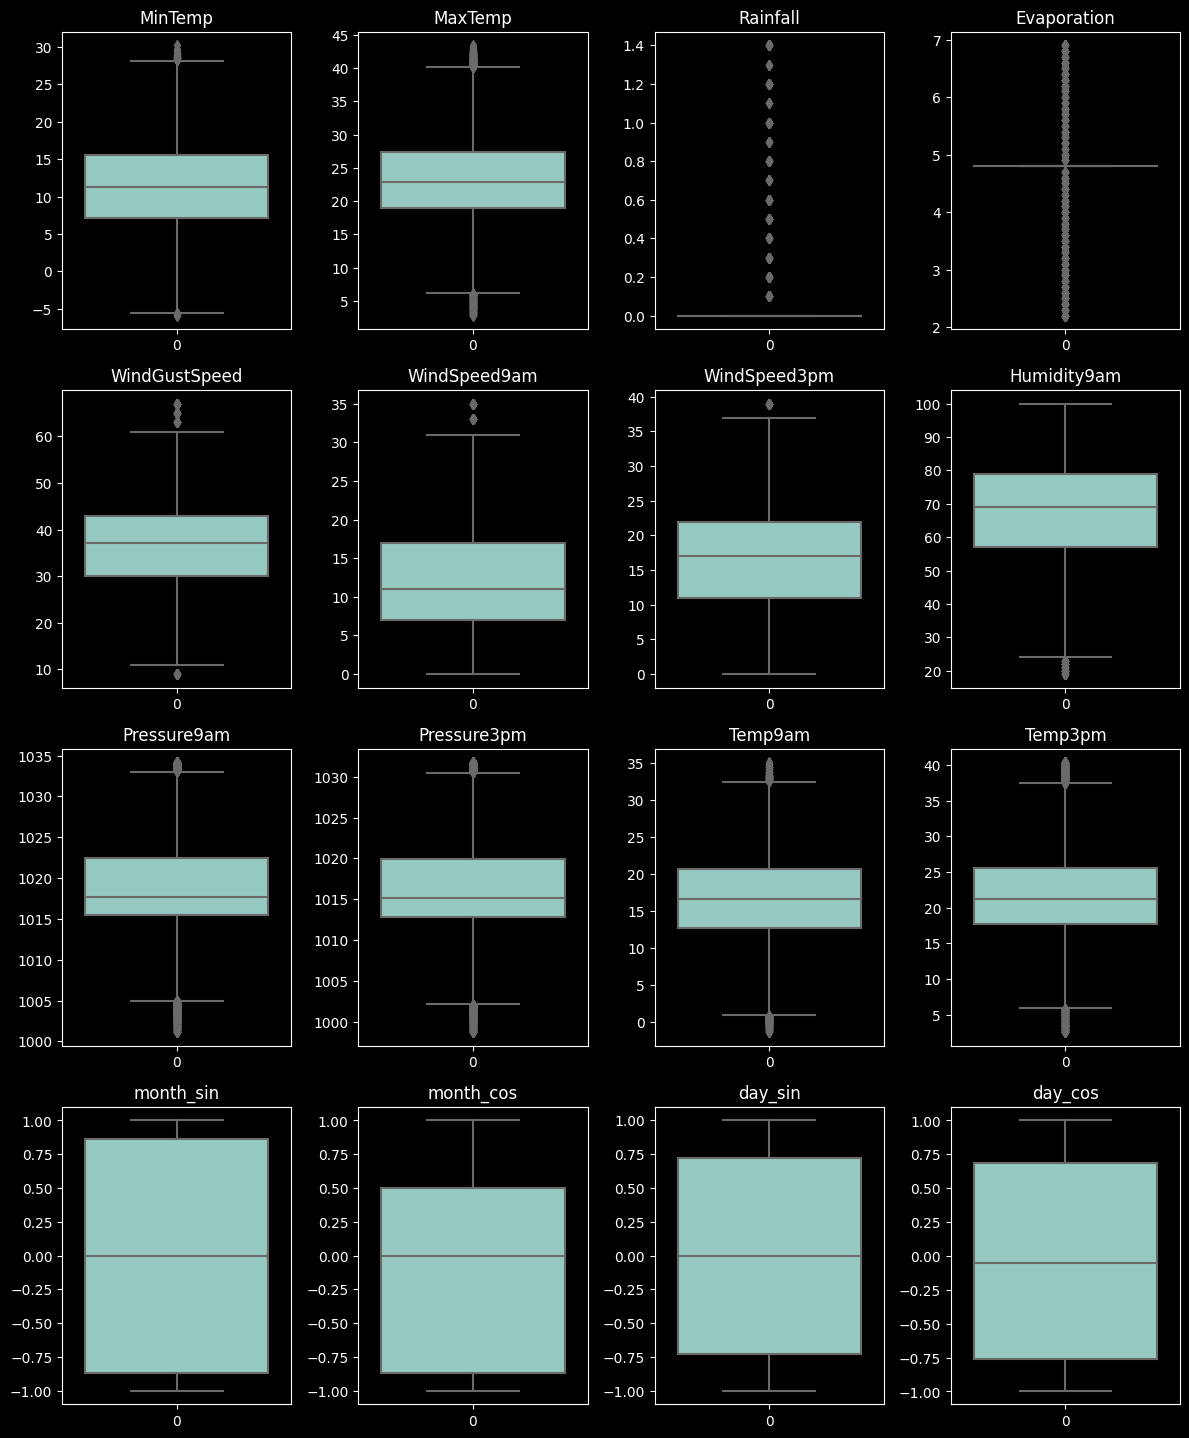

In [40]:
n = 1
plt.figure(figsize=(12, 25))
for feature in features_with_outliers:
  plt.subplot(7, 4, n, title=feature)
  n += 1
  sns.boxplot(df[feature])
  plt.tight_layout()

# 4. Model Building 



## 4.1. Label Encoding

In [65]:
cat_features = [feature for feature in df.columns if df[feature].dtype == "O"]

In [42]:
encoder = LabelEncoder()

In [43]:
for feature in cat_features:
  df[feature] = encoder.fit_transform(df[feature])

## 4.2. Feature Seggregeration

In [66]:
x =  df.drop("RainTomorrow", axis=1)
y = df["RainTomorrow"]

## 4.3. Resampling

In [45]:
smt = SMOTETomek(random_state=42, sampling_strategy="auto", n_jobs=-1)

In [46]:
x_resampled, y_resampled = smt.fit_resample(x, y)

## 4.4. Train Test Split

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=0)

## 4.5. Scaling

In [67]:
scaler = StandardScaler()

In [49]:
x_train_scaled = scaler.fit_transform(x_train)

In [50]:
x_test_scaled = scaler.transform(x_test)

## 4.6. Defining & Compiling the Neural Network

**Defining Callbacks**

In [51]:
callback_early_stopper = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

**Defining Model**

In [52]:
ann = Sequential(
    [
      Dense(input_dim=26, units=32, kernel_initializer="uniform", activation="relu", name="input_layer"),
      Dense(units=16, kernel_initializer="uniform", activation="relu", name="hidden_layer_1"),
      Dropout(0.25),
      Dense(units=8, kernel_initializer="uniform", activation="relu", name="hidden_layer_2"),
      Dropout(0.5),
      Dense(units=1, kernel_initializer="uniform", activation="sigmoid", name="output_laye")
    ]
)

In [53]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 32)                864       
                                                                 
 hidden_layer_1 (Dense)      (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 hidden_layer_2 (Dense)      (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 output_laye (Dense)         (None, 1)                 9         
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainabl

**Defining Optimizer**

In [54]:
optimizer = Adam(learning_rate=0.00009)

**Compiling the ANN**

In [55]:
ann.compile(
    optimizer=optimizer, 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
    )

**Training the ANN**

In [56]:
ann_train_history = ann.fit(
    x_train_scaled, y_train, 
    batch_size=50, epochs=200,
    callbacks=callback_early_stopper, 
    validation_split=0.2
    )

Epoch 1/200
1719/1719 [==============================] - 6s 2ms/step - loss: 0.6139 - accuracy: 0.6865 - val_loss: 0.5220 - val_accuracy: 0.7460
Epoch 2/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5432 - accuracy: 0.7400 - val_loss: 0.5098 - val_accuracy: 0.7508
Epoch 3/200
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5380 - accuracy: 0.7441 - val_loss: 0.5038 - val_accuracy: 0.7568
Epoch 4/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5306 - accuracy: 0.7484 - val_loss: 0.4980 - val_accuracy: 0.7598
Epoch 5/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5271 - accuracy: 0.7516 - val_loss: 0.4947 - val_accuracy: 0.7618
Epoch 6/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5242 - accuracy: 0.7534 - val_loss: 0.4909 - val_accuracy: 0.7647
Epoch 7/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5199 - accuracy: 0.7578 - val_loss: 0.4878 - val_ac

# 5. Model Evaluation

Best parameters for ANN

In [57]:
ann_train_history.params

{'verbose': 1, 'epochs': 200, 'steps': 1719}

Checkin the accuracy and loss of the ANN over epochs

In [58]:
ann_history_df = pd.DataFrame(ann_train_history.history)

In [59]:
ann_history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.613860,0.686450,0.522011,0.745984
1,0.543165,0.740004,0.509756,0.750826
2,0.537957,0.744148,0.503824,0.756832
3,0.530583,0.748373,0.497957,0.759765
4,0.527142,0.751574,0.494723,0.761767


**Training vs Validation Accuracy over Epochs**

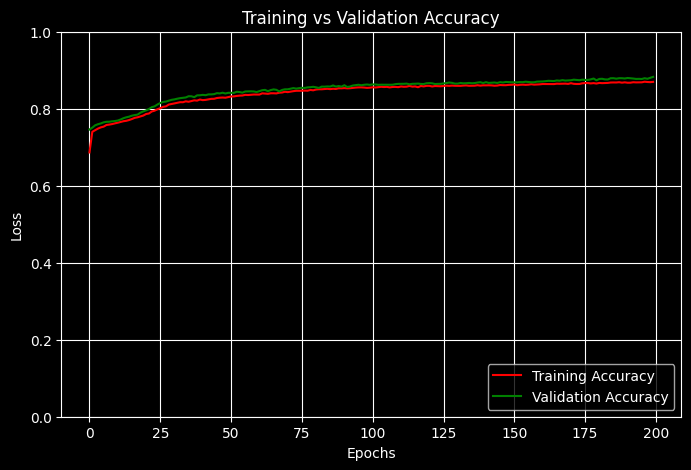

In [60]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.plot(ann_history_df.loc[:, ["accuracy"]], label="Training Accuracy", color="red")
plt.plot(ann_history_df.loc[:, ["val_accuracy"]], label="Validation Accuracy", color="green")

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower right")

plt.show() 

**Training vs Validation Loss over Epochs**

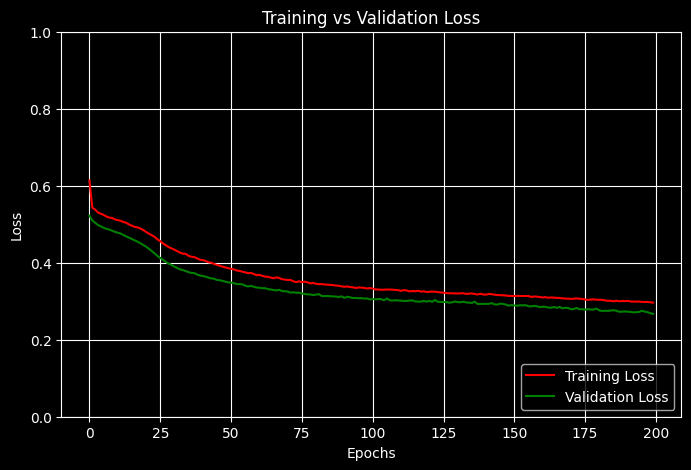

In [61]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.plot(ann_history_df.loc[:, ["loss"]], label="Training Loss", color="red")
plt.plot(ann_history_df.loc[:, ["val_loss"]], label="Validation Loss", color="green")

plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower right")

plt.show() 

**Predicting on Test dataset**

In [62]:
y_pred = ann.predict(x_test_scaled)

839/839 [==============================] - 1s 1ms/step


In [63]:
y_pred = (y_pred > 0.5)

**Plotting the Confusuin Matrix**

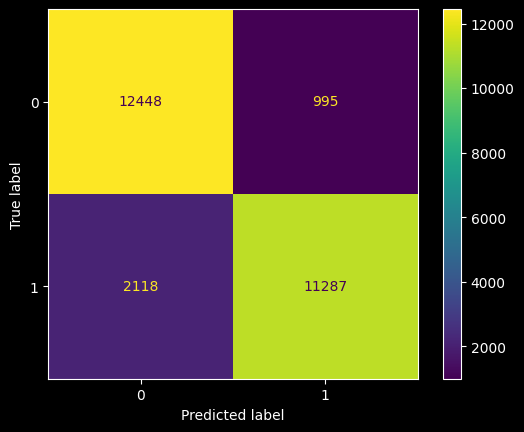

In [64]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()